# Import the Required Dependencies 


In [1]:
import numpy as np
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow as tf
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
import keras 
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.regularizers import l1
import os
import time
from time import time

def plot_learningCurve(history,num_epoch):
  # Plot training & validation accuracy values
  epoch_range = np.arange(1,num_epoch+1)
  plt.plot(epoch_range, history.history['acc'])
  plt.plot(epoch_range, history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

save_dir='/model/resnet'

Using TensorFlow backend.


## Note on Conv2D

In order to implement the convolutional layers, we use the Keras implementation of Conv2D. However, in all cases, you are required to use a specific kernel initializer so that the results are predictable ( random initialization of convolutional kernel would result in unpredictable ).

As such, please use the following Conv2D: 

Conv2D(filters=f, kernel_size=(k, k), strides=(s, s), padding=pad_type, kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)

In which f,k and s denote the size of filter,kernel and stride. Pad_type denoted the padding type which can be either "same" or "valid". 

##Implementing the Identity Block 

We discussed the identity block in the homework description. Here we provide the details of the components that you should use to implement it. 

The following represents the components: 

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the channels axis. No particular argument needs to be passed.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the channels axis. No particular argument needs to be passed.
- Then apply the ReLU activation function. This has no hyperparameters

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the channels axis. No particular argument needs to be passed. 
- Then apply the ReLU activation function. This has no hyperparameters

Final step: 
- The shortcut and the input are added together.
- Then apply the ReLU activation function. This has no hyperparameters

Useful links:

- [Conv](https://keras.io/layers/convolutional/#conv2d)
- [BatchNorm](https://keras.io/layers/normalization/#batchnormalization)
- For the activation, use:  `Activation('relu')(X)`
- [Addition](https://keras.io/layers/merge/#add)



In [0]:
def identity_block(X, f, filters):
    """
    Implementation of the identity block as defined in Figure 4 of homework

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path (e.g. [2,4,16])
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    # Retrieve Filters
    f_1 = filters[0]
    f_2 = filters[1]
    f_3 = filters[2]

    # Save the input value. You'll need this later to add back to the main path. 
    input_X = X

    # First component of main path
    X = Conv2D(filters=f_1, 
              kernel_size=(1, 1), 
              strides=(1, 1), 
              padding="valid", 
              kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=f_2, 
              kernel_size=(f, f), 
              strides=(1, 1), 
              padding="same", 
              kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=f_3, 
              kernel_size=(1, 1), 
              strides=(1, 1), 
              padding="valid", 
              kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, input_X])
    X = Activation('relu')(X)

    return X

##Testing the Identity Block

Simply run the code in the following block and report the result that is generated in your homework report. 

In [29]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [4, 4, 4, 8])
    X = np.random.randn(4,4,4,8)
    A = identity_block(A_prev, f=2, filters=[2, 4, 8])
    test.run(tf.global_variables_initializer())
    res = test.run([A], feed_dict={A_prev: X})
    print('Result = {}'.format(res[0][1][1][0]))


Result = [0.8278597  0.10646105 2.1855583  0.56990707 0.         1.6353136
 1.454914   1.1312441 ]


##Implementing the Convolutional Block 

We discussed the convolutional block in the homework description. Here we provide the details of the components that you should use to implement it. 

The following represents the components: 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". 
- The first BatchNorm is normalizing the channels axis. No particular argument needs to be passed.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of (f,f) and a stride of (1,1). Its padding is "same".
- The second BatchNorm is normalizing the channels axis. No particular argument needs to be passed.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of (1,1) and a stride of (1,1). Its padding is "valid".
- The third BatchNorm is normalizing the channels axis. No particular argument needs to be passed. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".
- The BatchNorm is normalizing the channels axis. BatchNorm is normalizing the channels axis. No particular argument needs to be passed

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Useful links:

- [Conv](https://keras.io/layers/convolutional/#conv2d)
- [BatchNorm](https://keras.io/layers/normalization/#batchnormalization)
- For the activation, use:  `Activation('relu')(X)`
- [Addition](https://keras.io/layers/merge/#add)

In [0]:
def convolutional_block(X, f, filters,stride=2):
    """
    Implementation of the convolutional block as defined in Figure 5 of homework

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path (e.g. [2,4,16])
    stride -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    f_1 = filters[0]
    f_2 = filters[1]
    f_3 = filters[2]

    # Save the input value
    input_X = X

    # First component of main path 
    X = Conv2D(filters=f_1, 
              kernel_size=(1, 1), 
              strides=(stride, stride), 
              padding="valid", 
              kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=f_2, 
              kernel_size=(f, f), 
              strides=(1, 1), 
              padding="same", 
              kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=f_3, 
              kernel_size=(1, 1), 
              strides=(1, 1), 
              padding="valid", 
              kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    input_X = Conv2D(filters=f_3, 
              kernel_size=(1, 1), 
              strides=(stride, stride), 
              padding="valid", 
              kernel_initializer=keras.initializers.glorot_uniform(seed=0))(input_X)
    input_X = BatchNormalization()(input_X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, input_X])
    X = Activation('relu')(X)

    return X


##Testing the Convolutional Block

Simply run the code in the following block and report the result that is generated in your homework report. 

In [35]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [4, 4, 4, 8])
    X = np.random.randn(4,4,4,8)
    A = convolutional_block(A_prev, f=2, filters=[2, 4, 8])
    test.run(tf.global_variables_initializer())
    res = test.run([A], feed_dict={A_prev: X})
    print('Result = {}'.format(res[0][1][1][0]))

Result = [0.        1.3407363 1.4184607 0.        0.        2.2878466 0.8547394
 0.5266884]


##Implementing ResNet 

We discussed the ResNet architecture in the homework description ( see Figure 6 ). Here we provide further details you should use to implement it.
The following represents ResNet components: 

- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1.
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3.
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2.
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3.
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2.
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3.
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2.
    - The 2 identity blocks use three set of filters of size [256, 256, 2048], "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The flatten doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

Useful links:

- [Conv](https://keras.io/layers/convolutional/#conv2d)
- [BatchNorm](https://keras.io/layers/normalization/#batchnormalization)
- For the activation, use:  `Activation('relu')(X)`
- [Addition](https://keras.io/layers/merge/#add)
- [Average pooling](https://keras.io/layers/pooling/#averagepooling2d)
- [Max pooling](https://keras.io/layers/pooling/#maxpooling2d)
- [Zero padding](https://keras.io/layers/convolutional/#zeropadding2d)



In [0]:
def ResNet(input_shape=(32, 32, 3), classes=10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D(padding=(3, 3), data_format=None)(X_input)

    # Stage 1
    X = Conv2D(filters=64, 
              kernel_size=(7, 7), 
              strides=(2, 2), 
              padding="valid", 
              kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(3, 3), 
                           strides=(2, 2), 
                           padding='valid', 
                           data_format=None)(X)
    
    # Stage 2
    X = convolutional_block(X, 3, [64, 64, 256], 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, 3, [128, 128, 512], 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, 3, [256, 256, 1024], 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    
    # Stage 5 (≈3 lines)
    X = convolutional_block(X, 3, [512, 512, 2048], 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    

    # AVGPOOL (≈1 line)
    X = AveragePooling2D(pool_size=(2, 2), 
                               strides=None, 
                               padding="same", 
                               data_format=None)(X)

    # output layer
    X = Flatten()(X)
    X = Dense(units=classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNe')

    return model

model = ResNet(input_shape=(32, 32, 3), classes=10)

##CIFAR10 Dataset

Simply run the following code block to download and preprocess the CIFAR10 dataset. We also use online data-augmentation to improve the results. 

In [47]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
num_classes = 10
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

datagen.fit(x_train)


170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


##Compile the Model

The following block sets the required hyper-parameters, complies the model starts the process of training and at the end saves the trained model. 

You can use your own hyper-parameters, but these have been tested to work properly.

Note that we require you to report the accuracy for models that have been trained for 50 epochs. 

In [48]:
batch_size = 2048
epochs = 50
data_augmentation = True
learning_rate=0.001

opt = keras.optimizers.adam(lr=learning_rate, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
t1=time()
history =model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)
print('Training time is {} s'.format(time()-t1))
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name='resnet'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50

25/25 [==============================] - 82s 3s/step - loss: 2.5152 - acc: 0.2245 - val_loss: 3.2390 - val_acc: 0.1406
Epoch 2/50
25/25 [==============================] - 21s 823ms/step - loss: 1.7607 - acc: 0.3537 - val_loss: 2.1377 - val_acc: 0.2651
Epoch 3/50
25/25 [==============================] - 25s 997ms/step - loss: 1.7049 - acc: 0.3944 - val_loss: 13.6726 - val_acc: 0.0924
Epoch 4/50
25/25 [==============================] - 25s 1s/step - loss: 1.5850 - acc: 0.4264 - val_loss: 4.0149 - val_acc: 0.2583
Epoch 5/50
25/25 [==============================] - 24s 976ms/step - loss: 1.4818 - acc: 0.4608 - val_loss: 1.6892 - val_acc: 0.4063
Epoch 6/50
25/25 [==============================] - 25s 992ms/step - loss: 1.4333 - acc: 0.4842 - val_loss: 1.6360 - val_acc: 0.4264
Epoch 7/50
25/25 [==============================] - 25s 999ms/step - loss: 1.3624 - acc: 0.5084 - val_loss: 

##Evaluate the model

Simply run the following block of code to plot accuracies on training and validation set during different training epochs and eventually get the **accuracy** of the trained model on the **testing set** of CIFAR10 dataset

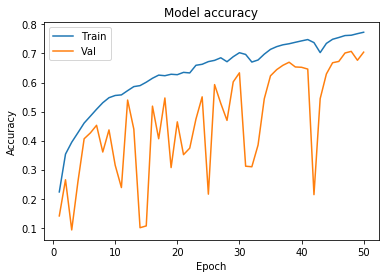

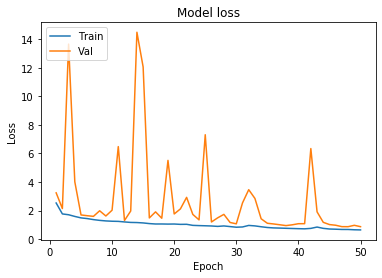

10000/10000 [==============================] - 5s 485us/step
Test loss: 0.8672622466087341
Test accuracy: 0.7046


In [49]:
plot_learningCurve(history,epochs)

# Evaluate trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
